## imports

In [2]:
import pandas as pd
import sqlite3


In [3]:
db = sqlite3.connect('../data/checking-logs.sqlite.sqlite')

## analyze only the users and not the admins

In [4]:
query = '''
SELECT uid, timestamp  FROM checker
WHERE uid LIKE 'user_%'
'''
commits = pd.io.sql.read_sql(query, db, parse_dates=['timestamp'])
commits

,uid,timestamp
0,user_4,2020-04-17 05:19:02.744528
1,user_4,2020-04-17 05:22:35.249331
2,user_4,2020-04-17 05:22:45.549397
3,user_4,2020-04-17 05:34:14.691200
4,user_4,2020-04-17 05:34:24.422370
...,...,...
3202,user_1,2020-05-21 20:19:06.872761
3203,user_1,2020-05-21 20:22:41.785725
3204,user_1,2020-05-21 20:22:41.877806
3205,user_1,2020-05-21 20:37:00.129678


## for each hour, calculate the average number of commits on working days and on
## weekends (if there were no commits in an hour, do not use it to calculate the
## average) use these values for your graph, for example: Mon, 17-18: 5 commits, Tue, 17-18: 6 commits, Wed, 17-18: 7 commits

In [5]:
commits['weekday'] = commits['timestamp'].dt.dayofweek
commits['hour'] = commits['timestamp'].dt.hour
commits['day'] = commits['timestamp'].dt.day
commits.head()

,uid,timestamp,weekday,hour,day
0,user_4,2020-04-17 05:19:02.744528,4,5,17
1,user_4,2020-04-17 05:22:35.249331,4,5,17
2,user_4,2020-04-17 05:22:45.549397,4,5,17
3,user_4,2020-04-17 05:34:14.691200,4,5,17
4,user_4,2020-04-17 05:34:24.422370,4,5,17


In [6]:
def set_type(x):
    if (x < 5):
        return 'working_day'
    else:
        return 'weekend'


In [7]:
commits['type'] = commits['weekday'].apply(set_type)
commits

,uid,timestamp,weekday,hour,day,type
0,user_4,2020-04-17 05:19:02.744528,4,5,17,working_day
1,user_4,2020-04-17 05:22:35.249331,4,5,17,working_day
2,user_4,2020-04-17 05:22:45.549397,4,5,17,working_day
3,user_4,2020-04-17 05:34:14.691200,4,5,17,working_day
4,user_4,2020-04-17 05:34:24.422370,4,5,17,working_day
...,...,...,...,...,...,...
3202,user_1,2020-05-21 20:19:06.872761,3,20,21,working_day
3203,user_1,2020-05-21 20:22:41.785725,3,20,21,working_day
3204,user_1,2020-05-21 20:22:41.877806,3,20,21,working_day
3205,user_1,2020-05-21 20:37:00.129678,3,20,21,working_day


In [8]:
group_commit = commits.groupby(['type', 'day', 'hour']).count()
group_commit = group_commit.groupby(['type', 'hour']).mean()['uid'].reset_index()
group_commit

,type,hour,uid
0,weekend,0,2.000000
1,weekend,1,6.000000
2,weekend,3,1.000000
3,weekend,5,2.000000
4,weekend,7,4.000000
5,weekend,8,7.000000
6,weekend,9,3.666667
7,weekend,10,7.000000
8,weekend,11,23.600000
9,weekend,12,9.500000


In [9]:
pivot_table = pd.pivot(group_commit, values='uid',index='hour', columns='type')
pivot_table

type,weekend,working_day
hour,,
0,2.000000,3.000000
1,6.000000,NaN
3,1.000000,2.000000
5,2.000000,7.500000
6,NaN,1.500000
7,4.000000,5.166667
8,7.000000,3.700000
9,3.666667,6.000000
10,7.000000,13.200000


In [10]:
hour = pd.DataFrame([i for i in range(0, 24)], columns=['hour'])
pivot_table = hour.merge(pivot_table, how='left', on='hour').set_index('hour')
pivot_table

,weekend,working_day
hour,,
0,2.000000,3.000000
1,6.000000,NaN
2,NaN,NaN
3,1.000000,2.000000
4,NaN,NaN
5,2.000000,7.500000
6,NaN,1.500000
7,4.000000,5.166667
8,7.000000,3.700000


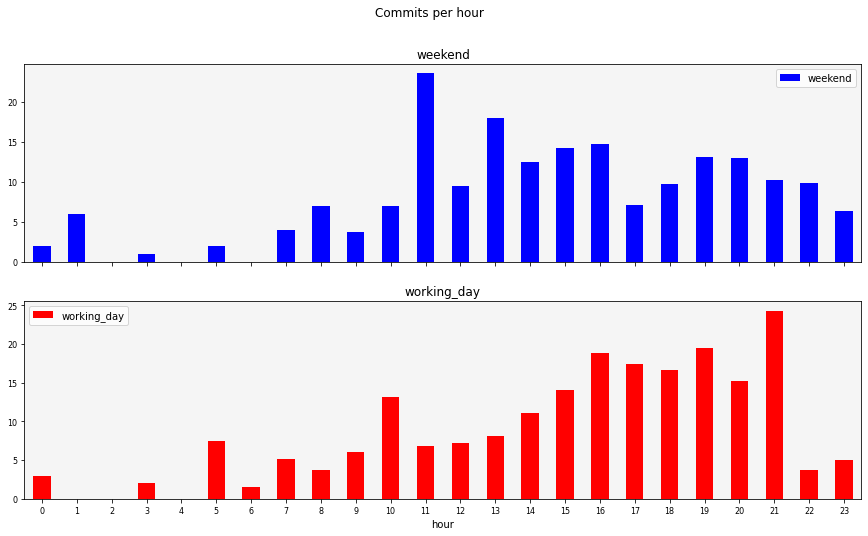

In [11]:
fig = pivot_table.plot(kind='bar',figsize=(15, 8),title='Commits per hour',rot=0,fontsize=8,color=['blue', 'red'],sharex=True, subplots=True)
fig[0].set_facecolor('#F5F5F5')
fig[1].set_facecolor('#F5F5F5')

## Is the dynamic different on working days and weekends?

In [12]:
pivot_table[pivot_table['working_day'] == pivot_table['working_day'].max()]

,weekend,working_day
hour,,
21,10.285714,24.333333


In [13]:
pivot_table[pivot_table['weekend'] == pivot_table['weekend'].max()]

,weekend,working_day
hour,,
11,23.6,6.769231


In [14]:
db.close()